In [1]:
import pandas as pd
import matplotlib.pyplot as plt

# load dataset into Pandas DataFrame
df = pd.read_csv("log.csv")
df.columns= ['timestamp','latency','gateway']
df = df.set_index('timestamp')
df = df.sort_index(axis=1)
df.head()


,gateway,latency
timestamp,,
01/21/19 02:32 PM,10.138.25.67,0.339817
01/21/19 02:33 PM,10.138.25.67,0.024861
01/21/19 02:34 PM,10.138.25.67,0.022789
01/21/19 02:35 PM,10.138.25.67,0.022000
01/21/19 02:36 PM,10.138.25.67,0.025834


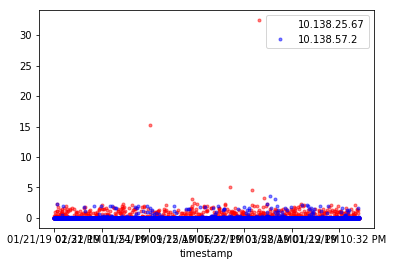

0.026701


In [2]:
fig, ax = plt.subplots()

colors = {'10.138.25.67':'red', '10.138.57.2':'blue'}

grouped = df.groupby('gateway')
for key, group in grouped:
    group.plot(ax=ax, style='.k',  y='latency', label=key, color=colors[key],alpha=0.5)

#plt.ylim(0,5)
plt.show()

print(df['latency'].quantile(0.9))



In [110]:
import pandas as pd
import matplotlib.pyplot as plt
import os


INPUT_DIR = os.path.join( os.getcwd(), "logs")
data = pd.DataFrame()
dirs = [f for f in os.listdir(INPUT_DIR) if os.path.isdir(os.path.join(INPUT_DIR))]    
#print(dirs)
data = {}
for client in dirs:
    files = [f for f in os.listdir(INPUT_DIR+"/"+client) if os.path.isdir(os.path.join(INPUT_DIR,client))]
    client_data = pd.DataFrame()
    for file in files:
        temp =  pd.read_csv(os.path.join(INPUT_DIR, client,file), sep=',')
        temp.columns= ['timestamp','ttfb','latency','gateway','status']
        client_data = pd.concat([client_data,temp])
    client_data = client_data.set_index(pd.DatetimeIndex(client_data['timestamp']))
    client_data.index = client_data.index.map(lambda x: x.replace(second=0, microsecond=0))
    client_data['timestamp'] = pd.DatetimeIndex(client_data['timestamp']).map(lambda x: x.replace(second=0, microsecond=0))

    data[client] = client_data


In [2]:
def get_min_date():
    min_date = None
    for d in data:
        c = data.get(d)
        if min_date is None or min_date > c.index.min():
            min_date = c.index.min()
    return min_date#.strftime("%m/%d/%Y, %H:%M:%S")

def get_max_date():
    max_date = None
    for d in data:
        c = data.get(d)
        if max_date is None or max_date > c.index.max():
            max_date = c.index.max()
    return max_date

def get_99th_percentile():
    df = pd.DataFrame()
    for d in data:
        df = pd.concat([df,data.get(d)])
    p90 = df['latency'].quantile(0.99)    
    return df.query('latency<'+str(p90))['latency'].mean()

def send_info(ts):
    min_date = None
    max_date = None
    
    gateway_table = pd.DataFrame()
    for d in data:
        c = data.get(d)[ts]
        c['sender'] = d
        if len(c)>2:
            gateway_table = pd.concat([gateway_table , c.sample(n=2)])
        elif len(c)>0:
            gateway_table = pd.concat([gateway_table , c])
    return gateway_table
    
import numpy as np
import math
def cosine_similarity(a,b):
    return sum([i*j for i,j in zip(a, b)])/(math.sqrt(sum([i*i for i in a]))* math.sqrt(sum([i*i for i in b])))
    
        
        

In [3]:
def calculate_trust_score(trust_score, gateway_table, noce):
    gateways = gateway_table.query('sender == "'+node+'"')
    rest = gateway_table.query('sender != "'+node+'"')
    rest = rest[rest.gateway.isin(gateways['gateway'].values)]
    for index, row in rest.iterrows():
        gw = gateways.query('gateway == "'+row['gateway']+'"')
        value = abs(gw['latency'].values[0] - row['latency'])

        if row['sender'] in trust_score:
            trust_score[row['sender']] = 2/3*value + 1/3*trust_score[row['sender']]
        else:
            trust_score[row['sender']] = value
    
    return trust_score

def calculate_trust_score_transitive(trust_score, gateway_table, node, topk):
    if len(trust_score)< topk:
        topk = len(trust_score)
    trust_score = dict(sorted(trust_score.items(),key=lambda kv: kv[1])[:topk])
    #print(trust_score)
    trusted = []
    trusted.extend(list(trust_score.keys()))
    if node not in trust_score:
        trusted.append(node)
        
    trusted_gw = gateway_table[gateway_table.sender.isin(trusted)]    
    gateways= trusted_gw['gateway'].unique()    
    
    mean_gateways = trusted_gw.groupby('gateway').mean()
    
    rest = gateway_table[~gateway_table.sender.isin(trusted)]
    rest = rest[rest.gateway.isin(gateways)]
    trusted_gw = trusted_gw.append(rest)
    
    for name, group in trusted_gw.groupby('sender'):
        if name == node:
            continue
        score = 0
        cnt = 0
        for index, row in group.iterrows():
            gw_value = mean_gateways.query('gateway == "'+row['gateway']+'"')['latency'].values[0]
            
            score += abs(gw_value - row['latency'])
            cnt +=1
            
        v = score/cnt
        #print(name, v)
        if name in trust_score:
            trust_score[name] = 2/3*v + 1/3*trust_score[name]
        else:
            trust_score[name] = v
    #print(trust_score)
        #print(name)
        #print(type(group))
    #print(mean_gateways)
    #print(trusted_gw[['gateway','latency','sender']])
    
    
    
    #gateway_table[~gateway_table.sender.isin(trusted)]
    #rest = rest[rest.gateway.isin(gateways['gateway'].values)]
    
    #print(gateways[['gateway', 'sender']])
    #print('=====================')
    #print(rest[['gateway', 'sender']])
    #print(rest[['gateway','sender']])
    #cnt = 0
    #for index, row in rest.iterrows():
    #    gw = gateways.query('gateway == "'+row['gateway']+'"')
    #    value = abs(gw['latency'].values[0] - row['latency'])

    #    if row['sender'] in trust_score:
    #        trust_score[row['sender']] = 2/3*value + 1/3*trust_score[row['sender']]
    #        cnt+=1
    #    else:
    #        trust_score[row['sender']] = value
    #        cnt+=1
    
    #print(cnt)
    
    return trust_score
    

In [4]:

# Gateway table with all collaborators and MA
def build_gateway_table(gateway_table, new_df, ts):
    #print(new_df['gateway'].unique())
    df_period = new_df.groupby(new_df['gateway'])
    actual = []
    gw_t = [] 
    
    for name, group in df_period:
        cnt = 1
        size = len(group)
        
        mv_value = 0
        if name in gateway_table:
            cnt +=1
            size +=1
            mv_value +=gateway_table[name]
        
        summa = sum(range(1,size+1))
        for index, row in group.iterrows():
            mv_value += cnt*row['latency']
            cnt +=1
        
        mv_value = mv_value/summa
        #print(name,mv_value)
        
        df_actual = data['c0_1'].query('timestamp == "'+ts+'" and gateway == "'+name+'"')
        if len(df_actual) >0:
            actual.append(df_actual['latency'].values[0])
            gw_t.append(mv_value)
    if len(actual) == 0 or len(gw_t) == 0:
        return None
    return cosine_similarity(actual, gw_t)
    
#Gateway table with latest measurement without ma
def build_gateway_table1(gateway_table, new_df, ts):
    df_period = new_df.groupby(new_df['gateway'])
    actual = []
    gw_t = [] 
    
    for name, group in df_period:
        size = len(group)
        mv_value = group['latency'].values[size-1]
        df_actual = data['c0_1'].query('timestamp == "'+ts+'" and gateway == "'+name+'"')
        if len(df_actual) >0:
            actual.append(df_actual['latency'].values[0])
            gw_t.append(mv_value)
            
            #print(name, mv_value, df_actual['latency'].values[0])
    if len(actual) == 0 or len(gw_t) == 0:
        return None
    return cosine_similarity(actual, gw_t)

#Gateway table with MA and TOP K collaborators (absolute error)
def build_gateway_table2(gateway_table, new_df, trust_score, ts):
    trusted_col = dict(sorted(trust_score.items(),key=lambda kv: kv[1])[:5])
    print(trusted_col)
    new_df = new_df[new_df.sender.isin(trusted_col.keys())]
    df_period = new_df.groupby(new_df['gateway'])
    actual = []
    gw_t = [] 
    for name, group in df_period:
        cnt = 1
        size = len(group)
        
        mv_value = 0
        if name in gateway_table:
            cnt +=1
            size +=1
            mv_value +=gateway_table[name]
        
        summa = sum(range(1,size+1))
        for index, row in group.iterrows():
            mv_value += cnt*row['latency']
            cnt +=1
        
        mv_value = mv_value/summa
        #print(name,mv_value)
        
        df_actual = data['c0_1'].query('timestamp == "'+ts+'" and gateway == "'+name+'"')
        if len(df_actual) >0:
            actual.append(df_actual['latency'].values[0])
            gw_t.append(mv_value)
    if len(actual) == 0 or len(gw_t) == 0:
        return None
    return cosine_similarity(actual, gw_t)

In [5]:
# Gateway table with all collaborators without MA
def build_gateway_table_no_ma(gateway_table, new_df,trust_score, ts):
    df_period = new_df.groupby(new_df['gateway'])
    actual = []
    gw_t = []     
    for name, group in df_period:        
        df_actual = data['c0_1'].query('timestamp == "'+ts+'" and gateway == "'+name+'"')
        if len(df_actual) >0:
            for index, row in group.iterrows():                
                actual.append(df_actual['latency'].values[0])
                gw_t.append(row['latency'])
                
    if len(actual) == 0 or len(gw_t) == 0:
        return None
    return cosine_similarity(actual, gw_t)

# Gateway table with TOP K collaborators without MA
def build_gateway_table_no_ma_topk(gateway_table, new_df,trust_score, ts, k):
    trusted_col = dict(sorted(trust_score.items(),key=lambda kv: kv[1])[:k])
    new_df = new_df[new_df.sender.isin(trusted_col.keys())]
    df_period = new_df.groupby(new_df['gateway'])
    actual = []
    gw_t = []     
    for name, group in df_period:        
        df_actual = data['c0_1'].query('timestamp == "'+ts+'" and gateway == "'+name+'"')
        if len(df_actual) >0:
            for index, row in group.iterrows():                
                actual.append(df_actual['latency'].values[0])
                gw_t.append(row['latency'])
                
    if len(actual) == 0 or len(gw_t) == 0:
        return None
    return cosine_similarity(actual, gw_t)

def build_gateway_table_ma_topk_error(gateway_table, new_df, trust_score, faulty_nodes):
    trusted_col = dict(sorted(trust_score.items(),key=lambda kv: kv[1])[:4])
    
    new_df = new_df[new_df.sender.isin(trusted_col.keys())]
    df_period = new_df.groupby(new_df['gateway'])
    actual = []
    gw_t = [] 
    for name, group in df_period:
        cnt = 1
        size = len(group)
        
        mv_value = 0
        if name in gateway_table:
            cnt +=1
            size +=1
            mv_value +=gateway_table[name]
        
        summa = sum(range(1,size+1))
        for index, row in group.iterrows():
            mv_value += cnt*row['latency']
            cnt +=1
        
        mv_value = mv_value/summa
        #print(name,mv_value)
        
        df_actual = data['c0_1'].query('timestamp == "'+ts+'" and gateway == "'+name+'"')
        if len(df_actual) >0:
            actual.append(df_actual['latency'].values[0])
            gw_t.append(mv_value)
    if len(actual) == 0 or len(gw_t) == 0:
        return None
    return cosine_similarity(actual, gw_t)

In [124]:
#print(data['c2_2'][['gateway','latency']]) 
#data['c2_2']['latency'] = data['c2_2']['latency']/10 
#data['c3_1']['latency'] = data['c3_1']['latency']/10 
data['c1_2']['latency'] = data['c1_2']['latency']/10 

In [119]:
print(data['c2_2']['latency'])

timestamp
2019-01-21 14:35:00    0.003386
2019-01-21 14:36:00    0.003327
2019-01-21 14:37:00    0.003405
2019-01-21 14:38:00    0.003327
2019-01-21 14:39:00    0.003318
2019-01-21 14:40:00    0.003267
2019-01-21 14:41:00    0.002972
2019-01-21 14:42:00    0.003410
2019-01-21 14:43:00    0.003505
2019-01-21 14:44:00    0.003407
2019-01-21 14:45:00    0.003441
2019-01-21 14:46:00    0.003702
2019-01-21 14:47:00    0.003662
2019-01-21 14:48:00    0.003627
2019-01-21 14:49:00    0.003513
2019-01-21 14:50:00    0.003419
2019-01-21 14:51:00    0.003152
2019-01-21 14:52:00    0.003468
2019-01-21 14:53:00    0.003358
2019-01-21 14:54:00    0.003217
2019-01-21 14:55:00    0.003273
2019-01-21 14:56:00    0.003150
2019-01-21 14:57:00    0.003212
2019-01-21 14:58:00    0.003130
2019-01-21 14:59:00    0.003130
2019-01-21 15:00:00    0.003516
2019-01-21 15:01:00    0.003019
2019-01-21 15:02:00    0.003345
2019-01-21 15:03:00    0.003032
2019-01-21 15:04:00    0.003078
                         ...  

In [125]:
import datetime

min_date = get_min_date() 
max_date = get_max_date() 

start = min_date
end_date = start+datetime.timedelta(minutes = 1440)

#end_date = start+datetime.timedelta(minutes = 100)
history_gateway_table = pd.DataFrame()
gateway_table = {}
trust_score = {}
trust_score_transitive = {}
clients = {}
gw_table_similarity_ma = pd.DataFrame()
gw_table_similarity = pd.DataFrame()
gw_table_similarity_ma_top = pd.DataFrame()

gw_table_similarity_no_ma = pd.DataFrame()
gw_table_similarity_no_ma_top4 = pd.DataFrame()
gw_table_similarity_no_ma_top5 = pd.DataFrame()
gw_table_similarity_no_ma_top6 = pd.DataFrame()
gw_table_similarity_no_ma_top7 = pd.DataFrame()
#f = open('similarity_abs.csv','w')
while(start < end_date):
    rt = send_info(start.strftime("%m/%d/%Y, %H:%M:%S"))
    gws = rt.query('sender=="c0_1"')['gateway'].values
    
    for index, row in rt.iterrows():
        if row["gateway"] in gws:
            if row['sender'] == "c0_1":
                continue
            if row["sender"] not in clients:
                clients[row["sender"]] = 1
            else:
                clients[row["sender"]] += 1
    
    #print(rt[['gateway','latency','sender']])
    
    
    history_gateway_table = pd.concat([history_gateway_table, rt])
    no_gws = len(history_gateway_table['gateway'].unique())
    #no_senders = len(history_gat)
    #trust_score = calculate_trust_score(trust_score, rt, 'c0_1')
    trust_score_transitive = calculate_trust_score_transitive(trust_score_transitive, rt, 'c0_1', 5)
    #print(rt.query('sender=="c2_2"')['latency'])
    print(sorted(trust_score_transitive.values()))
    
    #print(len(trust_score_transitive))
    
    #gw_table_similarity_no_ma = gw_table_similarity_no_ma.append({'timestamp':start.strftime("%m/%d/%Y, %H:%M:%S"),
    #                                                             'similarity':build_gateway_table_no_ma(gateway_table, rt, trust_score, start.strftime("%m/%d/%Y, %H:%M:%S"))}, 
    #                                                             ignore_index=True)
    #gw_table_similarity_no_ma_top4 = gw_table_similarity_no_ma_top4.append({'timestamp':start.strftime("%m/%d/%Y, %H:%M:%S"),
    #                                                             'similarity':build_gateway_table_no_ma_topk(gateway_table, rt, trust_score, start.strftime("%m/%d/%Y, %H:%M:%S"), 4)}, 
    #                                                             ignore_index=True)
    
    #gw_table_similarity_ma = gw_table_similarity_ma.append({'timestamp':start.strftime("%m/%d/%Y, %H:%M:%S"), 
    #                                                       'similarity':build_gateway_table(gateway_table, rt, start.strftime("%m/%d/%Y, %H:%M:%S"))}, 
    #                                                      ignore_index=True) 
    #gw_table_similarity = gw_table_similarity.append({'timestamp':start.strftime("%m/%d/%Y, %H:%M:%S"), 
    #                                                  'similarity':build_gateway_table1(gateway_table, rt, start.strftime("%m/%d/%Y, %H:%M:%S"))}, ignore_index=True)
    
    gw_table_similarity_ma_top = gw_table_similarity_ma_top.append({
        'timestamp':start.strftime("%m/%d/%Y, %H:%M:%S"), 
        'similarity':build_gateway_table2(gateway_table, rt, trust_score_transitive, start.strftime("%m/%d/%Y, %H:%M:%S"))
    },  ignore_index=True)
    start = start+datetime.timedelta(minutes=2)
gw_table_similarity_ma_top.to_csv('similarity_error_15%_min.csv')
#gw_table_similarity_ma.to_csv("similarity_abs_ma.csv")
#gw_table_similarity.to_csv("similarity_error_15%.csv")
#gw_table_similarity.to_csv("similarity.csv")
#print(gw_table_similarity)
    


C:\Users\Khulan\Anaconda3\lib\site-packages\ipykernel_launcher.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


[0.0011450000000000002, 0.0028569999999999984]
{'c0_2': 0.0011450000000000002, 'c0_3': 0.0028569999999999984}
[0.0006889999999999986, 0.0009523333333333328, 0.0048183333333333325, 0.0347715]
{'c1_3': 0.0006889999999999986, 'c0_3': 0.0009523333333333328, 'c0_2': 0.0048183333333333325, 'c1_2': 0.0347715}
[0.00031744444444444425, 0.0024606111111111105, 0.0033414166666666666, 0.011431074999999997, 0.0153112, 0.015602875, 0.026073000000000002, 0.027548, 0.027738633333333332, 0.03661149999999999, 0.041022575, 0.041820125, 0.045157749999999997, 0.05823099999999999, 0.0658535, 0.07366125, 0.20033625000000002, 0.276301375]
{'c0_3': 0.00031744444444444425, 'c0_2': 0.0024606111111111105, 'c1_3': 0.0033414166666666666, 'c2_1': 0.011431074999999997, 'c2_2': 0.0153112}
[0.0008202037037037034, 0.0030092481481481482, 0.00390957222222222, 0.005190300000000002, 0.005435358333333338, 0.007448000000000019, 0.009798933333333332, 0.012117499999999972, 0.015058000000000009, 0.02154499999999998, 0.02282099999

[0.004635, 0.005001721296296293, 0.01117044444444444, 0.011963666666666668, 0.016624389814814813, 0.01689833333333333, 0.017666333333333333, 0.019364166666666682, 0.021059333333333333, 0.024179899999999997, 0.03985179722222221, 0.05207290277777777, 0.0552291875, 0.06448999999999999, 0.09158736249999999, 0.14668266666666663, 0.171199, 0.21995983333333333]
{'c3_2': 0.004635, 'c2_1': 0.005001721296296293, 'c5_2': 0.01117044444444444, 'c0_2': 0.011963666666666668, 'c10_1': 0.016624389814814813}
[0.0034982499999999996, 0.0043922777777777875, 0.004536333333333342, 0.007321073765432096, 0.00836537037037036, 0.01426946327160494, 0.016492000000000007, 0.02162945, 0.02169975, 0.0254095, 0.029753666666666675, 0.03389565, 0.034391950000000004, 0.04217941666666669, 0.05583, 0.05851275, 0.08378675, 0.18584150000000002]
{'c0_3': 0.0034982499999999996, 'c3_2': 0.0043922777777777875, 'c0_2': 0.004536333333333342, 'c2_1': 0.007321073765432096, 'c5_2': 0.00836537037037036}
[0.0015759999999999993, 0.00270

[0.0029892111111111124, 0.0036771199512269466, 0.01110534259259259, 0.014300225, 0.019901349999999995, 0.02139925000000001, 0.025750655555555557, 0.032994499999999996, 0.036154124999999995, 0.037173250000000005, 0.04212725000000001, 0.044669966666666665, 0.046127466666666665, 0.05423987500000003, 0.06308774999999997, 0.10424450000000002, 0.12142425000000003, 0.13120025]
{'c0_3': 0.0029892111111111124, 'c1_1': 0.0036771199512269466, 'c3_1': 0.01110534259259259, 'c1_2': 0.014300225, 'c1_3': 0.019901349999999995}
[0.0015467066504089829, 0.008936024999999998, 0.016831016666666664, 0.018842091666666665, 0.022912500000000002, 0.030598049999999995, 0.03497317499999998, 0.04253285, 0.042827675000000016, 0.043003825, 0.050452480864197534, 0.052398220370370376, 0.07112869999999999, 0.07298735, 0.08417435, 0.10103335, 0.10175065000000003, 0.20284670000000002]
{'c1_1': 0.0015467066504089829, 'c0_2': 0.008936024999999998, 'c1_3': 0.016831016666666664, 'c1_2': 0.018842091666666665, 'c5_1': 0.0229125

[0.0023524444444444465, 0.003464924897119342, 0.007080916666666666, 0.009962375, 0.0167895, 0.020066666666666674, 0.020925600000000003, 0.021817361111111117, 0.025725583333333336, 0.03579138888888889, 0.04217858333333333, 0.050472083333333334, 0.05582066666666667, 0.06919666666666667, 0.2145287, 0.21868655, 0.25141308333333334, 0.44128]
{'c0_2': 0.0023524444444444465, 'c2_1': 0.003464924897119342, 'c1_1': 0.007080916666666666, 'c1_3': 0.009962375, 'c7_2': 0.0167895}
[0.00201230829903978, 0.002360305555555555, 0.0033207916666666668, 0.006635814814814815, 0.007966999999999998, 0.01921149999999998, 0.023155500000000002, 0.030654000000000018, 0.0315905, 0.04106083333333331, 0.0530075, 0.05531050000000001, 0.0635655, 0.0891005, 0.10746150000000004, 0.15779534999999997, 0.1784193, 0.18035639999999997]
{'c2_1': 0.00201230829903978, 'c1_1': 0.002360305555555555, 'c1_3': 0.0033207916666666668, 'c0_2': 0.006635814814814815, 'c3_2': 0.007966999999999998}
[0.0018772638888888888, 0.0031294938271604

[0.002214108024691357, 0.002793594444444445, 0.0050685, 0.005184783333333333, 0.009303499999999992, 0.010789322222222215, 0.014417349999999999, 0.025030250000000004, 0.028433000000000007, 0.033961250000000026, 0.039843250000000004, 0.043038999999999994, 0.050415, 0.059487000000000005, 0.09349100000000002, 0.10037624999999997, 0.10843574999999997, 0.2408033]
{'c0_2': 0.002214108024691357, 'c3_2': 0.002793594444444445, 'c2_2': 0.0050685, 'c1_3': 0.005184783333333333, 'c1_1': 0.009303499999999992}
[0.0009311981481481483, 0.0031865, 0.003859924897119358, 0.00832585, 0.00836461111111111, 0.013338800000000001, 0.021994524999999997, 0.022721611111111102, 0.0270785, 0.03293600000000001, 0.0358315, 0.038925049999999996, 0.046532000000000004, 0.054659525, 0.07055352499999999, 0.11023264166666666, 0.12712866666666667, 0.1282905]
{'c3_2': 0.0009311981481481483, 'c0_3': 0.0031865, 'c0_2': 0.003859924897119358, 'c2_2': 0.00832585, 'c1_3': 0.00836461111111111}
[8.450000000000124e-05, 0.00160566666666

[0.0015791555555555545, 0.004572166666666667, 0.005020100000000001, 0.007315627777777776, 0.010912396604938267, 0.011382000000000003, 0.012726874999999999, 0.013436499999999997, 0.014537074999999998, 0.0332441, 0.039462, 0.043245000000000006, 0.04728215, 0.076017, 0.10931932500000002, 0.205373125, 0.26289245, 0.31724235]
{'c0_2': 0.0015791555555555545, 'c0_3': 0.004572166666666667, 'c3_2': 0.005020100000000001, 'c3_1': 0.007315627777777776, 'c1_1': 0.010912396604938267}
[0.0024488333333333345, 0.0029473907407407403, 0.007889491666666668, 0.0253166, 0.03976144999999999, 0.04374450925925926, 0.045875725, 0.052735725, 0.06663422499999998, 0.074858725, 0.10402622499999997, 1.1099867250000002, 1.1880476877572015, 1.2249282166666666, 1.7714611666666666, 1.791484225, 1.865906, 1.92064925]
{'c0_3': 0.0024488333333333345, 'c0_2': 0.0029473907407407403, 'c2_1': 0.007889491666666668, 'c2_2': 0.0253166, 'c10_4': 0.03976144999999999}
[0.0014190000000000001, 0.00480450000000001, 0.00527980524691358,

[0.005326759259259253, 0.010324154702027117, 0.01120877777777778, 0.013431018518518521, 0.017592599999999996, 0.020239456790123445, 0.021395666666666664, 0.036528566666666665, 0.0624315, 0.09179300000000003, 0.1070035, 0.145757, 0.15396300000000002, 0.18205799999999994, 0.2545853333333333, 0.297101, 0.32535715, 0.4503095]
{'c5_1': 0.005326759259259253, 'c1_3': 0.010324154702027117, 'c2_1': 0.01120877777777778, 'c1_1': 0.013431018518518521, 'c3_1': 0.017592599999999996}
[0.0028960000000000027, 0.0034413849006757055, 0.009380759259259259, 0.010245249999999989, 0.01660875, 0.019179249999999988, 0.025694966666666673, 0.026898, 0.027603499999999996, 0.034886466666666636, 0.04238, 0.04683473086419751, 0.05328915061728394, 0.06224299999999999, 0.06624415, 0.08286571666666664, 0.08473646666666665, 0.09042648888888889]
{'c3_2': 0.0028960000000000027, 'c1_3': 0.0034413849006757055, 'c2_1': 0.009380759259259259, 'c7_1': 0.010245249999999989, 'c1_2': 0.01660875}
[0.001647166666666667, 0.0021062500

[0.0026529000000000014, 0.003028260082304526, 0.003034324999999999, 0.004747433333333334, 0.007338919753086412, 0.007459000000000007, 0.016427116666666665, 0.018534227777777773, 0.026637599999999997, 0.031381425, 0.032476175, 0.03769525000000001, 0.04546630000000001, 0.0685676, 0.08019425000000001, 0.08661425, 0.09974775, 0.19751799999999997]
{'c0_3': 0.0026529000000000014, 'c0_2': 0.003028260082304526, 'c1_3': 0.003034324999999999, 'c3_2': 0.004747433333333334, 'c2_1': 0.007338919753086412}
[0.001032253360768175, 0.0025804972222222217, 0.0036803, 0.004509084362139915, 0.00571625, 0.006166866666666667, 0.0144596, 0.017809916666666665, 0.0188785, 0.02399175, 0.028074, 0.031145166666666668, 0.04102625, 0.05975216666666666, 0.06401575, 0.0708575, 0.07179600000000001, 0.095676]
{'c0_2': 0.001032253360768175, 'c1_3': 0.0025804972222222217, 'c0_3': 0.0036803, 'c2_1': 0.004509084362139915, 'c1_1': 0.00571625}
[0.0011130011202560594, 0.0018198500000000002, 0.0026995824074074067, 0.003040194787

[0.006427721230672834, 0.0064855524691358, 0.007047999999999943, 0.00717878566529492, 0.009011599999999998, 0.01607735, 0.01724605, 0.02088015, 0.027125349999999996, 0.032618999999999995, 0.03438961111111112, 0.0350045, 0.039764849999999984, 0.0409591, 0.06391119999999999, 0.07580075, 0.08802955, 0.0926062]
{'c1_1': 0.006427721230672834, 'c0_3': 0.0064855524691358, 'c1_3': 0.007047999999999943, 'c0_2': 0.00717878566529492, 'c2_2': 0.009011599999999998}
[0.0028480181880020557, 0.003003866666666666, 0.005163166666666667, 0.005777649999999997, 0.008855517489711907, 0.009526000000000007, 0.03277173333333333, 0.0339979, 0.03773633333333333, 0.04833064999999999, 0.05195444444444439, 0.05366283333333334, 0.058650333333333346, 0.06099365077732054, 0.07107379999999999, 0.10565206666666663, 0.22632908333333338, 0.39859043333333327]
{'c1_1': 0.0028480181880020557, 'c2_2': 0.003003866666666666, 'c1_2': 0.005163166666666667, 'c3_2': 0.005777649999999997, 'c0_3': 0.008855517489711907}
[0.00335941666

[0.0005739538408779042, 0.0033607205940370333, 0.004590620370370369, 0.004803475617283951, 0.0063854537037037135, 0.027522450000000004, 0.027752000000000002, 0.036277500000000004, 0.03700116666666667, 0.06348737499999998, 0.07518933333333332, 0.08281325000000003, 0.08290874999999998, 0.08294174999999998]
{'c0_3': 0.0005739538408779042, 'c1_1': 0.0033607205940370333, 'c1_3': 0.004590620370370369, 'c0_2': 0.004803475617283951, 'c3_2': 0.0063854537037037135}
[0.0016874290580704138, 0.0021284845679012377, 0.0022487957535679, 0.013214283333333332, 0.0152574, 0.028148666666666666, 0.02980555, 0.03342424999999998, 0.034487000000000004, 0.03900250000000002, 0.059973706790123475, 0.060067325205761316, 0.07374700000000001, 0.07515900000000003, 0.07626900000000003, 0.117791, 0.15390225000000002, 0.29576924999999993]
{'c0_3': 0.0016874290580704138, 'c3_2': 0.0021284845679012377, 'c1_1': 0.0022487957535679, 'c2_2': 0.013214283333333332, 'c3_1': 0.0152574}
[0.00440476111111111, 0.006481731908245693,

[0.002856225308641975, 0.003291648148148148, 0.003650444444444443, 0.032288750000000005, 0.049334583333333334, 0.07236950000000003, 0.0769625, 0.08057533333333333, 0.08594049999999995, 0.1559952, 0.15945278364197524, 0.2033936666666668, 0.21905541234567896, 0.22029841666666666, 0.29249099999999995, 0.4358956666666666, 0.6523653333333332, 0.8362672333333333]
{'c3_2': 0.002856225308641975, 'c0_2': 0.003291648148148148, 'c1_1': 0.003650444444444443, 'c7_2': 0.032288750000000005, 'c7_1': 0.049334583333333334}
[6.799999999994311e-06, 0.0046384148148148115, 0.006943799999999993, 0.0080294999999998, 0.022684861111111107, 0.023286999999999995, 0.023609983333333334, 0.0321476, 0.0354371, 0.040067799999999994, 0.11124531604938274, 0.11242417510288065, 0.16600775000000006, 0.23845425000000006, 1.3278852, 1.5375632000000001]
{'c1_3': 6.799999999994311e-06, 'c1_1': 0.0046384148148148115, 'c0_3': 0.006943799999999993, 'c10_1': 0.0080294999999998, 'c7_1': 0.022684861111111107}
[0.00011800000000000005

[0.0037384999999999988, 0.003915636111111112, 0.0039207083333333325, 0.004681325, 0.036642499999999995, 0.043674722222222184, 0.06109298888888887, 0.06602408333333332, 0.07376758333333332, 0.08845448333333332, 0.1158879166666667, 0.12543829999999997, 0.22020787500000003, 0.2895927875, 0.31811995833333334, 0.3557002875, 0.63800725]
{'c1_3': 0.0037384999999999988, 'c1_2': 0.003915636111111112, 'c3_1': 0.0039207083333333325, 'c2_2': 0.004681325, 'c7_2': 0.036642499999999995}
[0.006618852777777775, 0.0071277499999999995, 0.008260658333333332, 0.010545945370370369, 0.012702750000000006, 0.01643725, 0.01650300000000001, 0.018317816666666667, 0.035895250000000004, 0.04727787500000001, 0.07507475, 0.08485237499999998, 0.10071759999999999, 0.11563300000000001, 0.17586355, 0.22586102499999997, 0.39042555, 0.482978175]
{'c3_1': 0.006618852777777775, 'c1_3': 0.0071277499999999995, 'c2_2': 0.008260658333333332, 'c1_2': 0.010545945370370369, 'c0_3': 0.012702750000000006}
[0.0028582194444444443, 0.00

[0.0029423000000000006, 0.004549099999999999, 0.006655499999999993, 0.010263389814814816, 0.012512252777777778, 0.015650199999999996, 0.04633782499999999, 0.0655020125, 0.10315869999999999, 0.13034635, 0.2539372, 0.256718, 1.139291310116598, 1.1430884916666666, 1.7096745, 1.7228151, 3.366373, 3.438171]
{'c3_1': 0.0029423000000000006, 'c1_1': 0.004549099999999999, 'c0_2': 0.006655499999999993, 'c2_2': 0.010263389814814816, 'c0_3': 0.012512252777777778}
[0.005112849999999997, 0.006039133333333332, 0.01569413425925926, 0.01590561327160494, 0.028059824999999997, 0.028239000000000004, 0.05261425000000001, 0.057932649999999995, 0.058896000000000004, 0.05932102500000001, 0.07496678333333331, 0.08603252500000001, 0.08664239999999998, 0.12425502499999999, 0.170013, 0.20748879999999997, 0.20975500000000005, 0.21760652499999997]
{'c0_2': 0.005112849999999997, 'c1_1': 0.006039133333333332, 'c0_3': 0.01569413425925926, 'c2_2': 0.01590561327160494, 'c2_1': 0.028059824999999997}
[0.002864377777777777

[0.007724000000000009, 0.009716149999999991, 0.011673150000000026, 0.01320061111111111, 0.013988368480132319, 0.014610999999999999, 0.015823383333333333, 0.021953233333333332, 0.0330168, 0.03364435, 0.034637150000000005, 0.037270399999999995, 0.044355000000000006, 0.050754999999999995, 0.08554300000000001, 0.14016800000000001, 0.15174215, 0.159605]
{'c3_2': 0.007724000000000009, 'c0_3': 0.009716149999999991, 'c0_2': 0.011673150000000026, 'c5_1': 0.01320061111111111, 'c1_1': 0.013988368480132319}
[0.005606550000000009, 0.006751456160044106, 0.008094383333333326, 0.009897166666666669, 0.01201075, 0.0143467037037037, 0.0164865, 0.0170807, 0.03685000000000001, 0.037781999999999996, 0.038415000000000005, 0.05949925000000002, 0.06938875, 0.074598, 0.07773050000000001, 0.08683000000000002, 0.10101650000000001, 0.18467175]
{'c0_2': 0.005606550000000009, 'c1_1': 0.006751456160044106, 'c0_3': 0.008094383333333326, 'c3_2': 0.009897166666666669, 'c3_1': 0.01201075}
[0.00598851666666667, 0.00623380

[0.0026853362139917687, 0.003448919753086431, 0.0055060000000000005, 0.009652266666666666, 0.0126567, 0.014672749999999981, 0.015250016666666666, 0.016715733333333337, 0.016851749999999995, 0.0191225, 0.026718500000000003, 0.03173483333333333, 0.03565295, 0.04256675, 0.08167525, 0.08193774999999998, 0.092771, 0.09978824999999997]
{'c0_2': 0.0026853362139917687, 'c0_3': 0.003448919753086431, 'c1_3': 0.0055060000000000005, 'c1_1': 0.009652266666666666, 'c1_2': 0.0126567}
[0.0015917787379972556, 0.003873806584362142, 0.004218899999999999, 0.005263999999999998, 0.007942644444444445, 0.011283883333333333, 0.011414944444444441, 0.014402000000000002, 0.03201905, 0.040228, 0.045144466666666674, 0.06044225, 0.07758555, 0.10632771666666667, 0.23732050000000005, 0.27823095000000003, 0.44465711666666674, 0.7987169000000001]
{'c0_2': 0.0015917787379972556, 'c0_3': 0.003873806584362142, 'c1_2': 0.004218899999999999, 'c2_1': 0.005263999999999998, 'c1_1': 0.007942644444444445}
[0.00225559291266575, 0.

[0.005361781481481483, 0.009454500000000001, 0.009747863671696382, 0.012162666666666669, 0.01404433333333334, 0.017027111111111114, 0.0192325, 0.02061425, 0.02253388888888887, 0.03742441666666667, 0.04071000000000001, 0.04611591666666667, 0.05217450000000001, 0.059919200000000006, 0.06381916666666665, 0.0948020833333333, 0.12037049999999999, 0.14367115000000003]
{'c5_3': 0.005361781481481483, 'c5_1': 0.009454500000000001, 'c5_2': 0.009747863671696382, 'c3_2': 0.012162666666666669, 'c2_1': 0.01404433333333334}
[0.0032492878905654604, 0.0065132777777777776, 0.007937, 0.00860226049382716, 0.010019750000000004, 0.015442666666666662, 0.01634538888888889, 0.01752225, 0.017617000000000004, 0.01987725, 0.022579500000000016, 0.024863249999999996, 0.03592849999999998, 0.048469, 0.052615499999999996, 0.052989499999999995, 0.072625, 0.0910252]
{'c5_2': 0.0032492878905654604, 'c2_1': 0.0065132777777777776, 'c0_2': 0.007937, 'c5_3': 0.00860226049382716, 'c1_3': 0.010019750000000004}
[0.0028674201646

[0.0006705495351318393, 0.0031270611111111108, 0.003379999999999998, 0.003486974927602501, 0.0075005, 0.0176416, 0.028198000000000004, 0.03072155, 0.03646005, 0.04234007412375033, 0.049803, 0.05141126666666666, 0.065349, 0.06700183333333333, 0.10233085000000001, 0.12253568333333333, 0.13069735, 0.13760835000000002]
{'c3_2': 0.0006705495351318393, 'c1_1': 0.0031270611111111108, 'c0_2': 0.003379999999999998, 'c0_3': 0.003486974927602501, 'c3_1': 0.0075005}
[0.001126666666666666, 0.004283308309200833, 0.005083516511710611, 0.009120975, 0.00997075, 0.020432649999999972, 0.022567825000000027, 0.028795825000000025, 0.0289297, 0.033417, 0.045616475000000004, 0.05984447500000001, 0.08479495, 0.08575500000000001, 0.09394149999999998, 0.10519657037037036, 0.10560436666666664, 0.28863982499999996]
{'c0_2': 0.001126666666666666, 'c0_3': 0.004283308309200833, 'c3_2': 0.005083516511710611, 'c1_3': 0.009120975, 'c1_2': 0.00997075}
[0.003040325, 0.0031223388372368815, 0.005743002769733604, 0.006825088

[0.00016532228953919514, 0.001059544196815827, 0.005071499999999994, 0.04823114227815224, 0.051989259928853795, 0.0579941, 0.06411710000000001, 0.0715576, 0.073504, 0.076382, 0.08538849999999999, 0.09314281666666666, 0.09755481666666665, 0.09808715555555556, 0.11229085, 0.15352181666666667, 0.1642765, 0.16711973333333335]
{'c0_2': 0.00016532228953919514, 'c0_3': 0.001059544196815827, 'c3_2': 0.005071499999999994, 'c1_1': 0.04823114227815224, 'c1_3': 0.051989259928853795}
[0.0063113888888888855, 0.013814, 0.03017315, 0.033519, 0.03507277409651307, 0.0490515, 0.053619999999999945, 0.05412653108739572, 0.055954, 0.060864999999999995, 0.08739051473227194, 0.10207482520382853, 0.13036999999999999, 0.164903, 0.19878999999999997, 0.20257616666666672, 0.3323387, 0.39392326666666666]
{'c3_2': 0.0063113888888888855, 'c2_1': 0.013814, 'c1_2': 0.03017315, 'c7_2': 0.033519, 'c0_2': 0.03507277409651307}
[0.00410087962962963, 0.00995583333333334, 0.012058625000000002, 0.013080000000000425, 0.01564550

[0.0031009999999999996, 0.0032654999999999976, 0.0035300181481481485, 0.0035982037037037037, 0.0044534166666666646, 0.005835780199156632, 0.008765026296296295, 0.01005505, 0.01677825, 0.019487499999999998, 0.026897599999999997, 0.0339945, 0.058992175, 0.06156742500000001, 0.07078042499999998, 0.073739425, 0.07434349999999998]
{'c0_2': 0.0031009999999999996, 'c0_3': 0.0032654999999999976, 'c1_1': 0.0035300181481481485, 'c1_3': 0.0035982037037037037, 'c2_1': 0.0044534166666666646}
[0.0015142345679012336, 0.003092166666666666, 0.004687999999999999, 0.005477506049382715, 0.006374805555555555, 0.0233338, 0.024663500000000005, 0.0306125, 0.03513574999999999, 0.03899174999999999, 0.052832500000000004, 0.0683465, 0.076596, 0.11546135, 0.116998, 0.1217885, 0.13553525, 0.20755385]
{'c1_3': 0.0015142345679012336, 'c0_3': 0.003092166666666666, 'c0_2': 0.004687999999999999, 'c1_1': 0.005477506049382715, 'c2_1': 0.006374805555555555}
[0.0009797499999999997, 0.0011687222222222212, 0.00266957818930042

[0.003254749999999999, 0.004524333333333332, 0.004939583333333339, 0.009924999999999962, 0.014252666666666667, 0.01747, 0.022374866666666667, 0.02354088888888889, 0.027838081481481484, 0.03748017777777777, 0.04153900000000005, 0.04271700000000001, 0.046039056172839495, 0.054832333333333344, 0.06458915, 0.07057225, 0.07980249999999997, 0.10032375]
{'c3_2': 0.003254749999999999, 'c2_1': 0.004524333333333332, 'c0_3': 0.004939583333333339, 'c5_1': 0.009924999999999962, 'c7_2': 0.014252666666666667}
[0.003963666666666666, 0.0069809999999999595, 0.007174583333333334, 0.007298250000000002, 0.016606833333333335, 0.017858199999999998, 0.02109638333333333, 0.026961750000000013, 0.027175500000000002, 0.02920133333333332, 0.03153474999999998, 0.03400599999999998, 0.03422350000000002, 0.042205999999999966, 0.0541895, 0.058258250000000004, 0.06110366666666667, 0.13075566666666666]
{'c2_1': 0.003963666666666666, 'c5_3': 0.0069809999999999595, 'c3_2': 0.007174583333333334, 'c0_3': 0.007298250000000002

[0.0020575999999999997, 0.008532151234567902, 0.009292083333333343, 0.019791583333333335, 0.02641899999999999, 0.029835999999999974, 0.031078444444444433, 0.03775396296296295, 0.05969500000000001, 0.07523416666666664, 0.09902133333333332, 0.11095733333333334, 0.14211549999999998, 0.18336399999999997, 0.187599, 0.23900285, 0.3198145, 0.41093795]
{'c3_1': 0.0020575999999999997, 'c10_3': 0.008532151234567902, 'c10_1': 0.009292083333333343, 'c10_2': 0.019791583333333335, 'c5_2': 0.02641899999999999}
[0.0013925000000000048, 0.003097361111111114, 0.005055749999999994, 0.01110983333333334, 0.015027249999999999, 0.015710027777777774, 0.01791916666666666, 0.026191200000000005, 0.02993250000000002, 0.05559988333333333, 0.055972044444444445, 0.0628313059670782, 0.0640675, 0.07622126666666666, 0.10944024999999999, 0.1324295, 0.14978375, 0.1926363833333333]
{'c10_4': 0.0013925000000000048, 'c10_1': 0.003097361111111114, 'c5_1': 0.005055749999999994, 'c3_2': 0.01110983333333334, 'c7_2': 0.0150272499

[0.0012307943415637858, 0.006119229166666668, 0.00782, 0.010736599999999997, 0.012869999999999998, 0.014454000000000002, 0.018929121296296293, 0.020050000000000012, 0.030514999999999997, 0.03222950000000002, 0.032520900000000005, 0.039772699999999994, 0.039888044444444444, 0.0416762, 0.056754400000000024, 0.069768, 0.0723652, 0.241165]
{'c1_3': 0.0012307943415637858, 'c1_1': 0.006119229166666668, 'c0_2': 0.00782, 'c2_1': 0.010736599999999997, 'c3_2': 0.012869999999999998}
[0.002606666666666667, 0.004742866666666665, 0.006994999999999998, 0.007591409722222223, 0.00806893144718793, 0.013420849999999998, 0.015165950000000001, 0.016616000000000027, 0.017323000000000033, 0.021269499999999955, 0.031436500000000006, 0.0413405, 0.04369650000000002, 0.04846800000000001, 0.054948, 0.0590755, 0.0736885, 0.14976615000000001]
{'c0_2': 0.002606666666666667, 'c2_1': 0.004742866666666665, 'c3_2': 0.006994999999999998, 'c1_1': 0.007591409722222223, 'c1_3': 0.00806893144718793}
[0.0028624699074074078, 0

[0.0016602864197531038, 0.0025480000000000086, 0.00319978244170094, 0.01145326193415635, 0.012802300000000023, 0.01895927407407409, 0.02512260000000005, 0.03246, 0.034290800000000045, 0.06462725, 0.06485224999999997, 0.067719, 0.06987480000000007, 0.07456129999999998, 0.07531260000000012, 0.11867425000000001, 0.12361620000000001, 0.21220194999999997]
{'c2_1': 0.0016602864197531038, 'c3_2': 0.0025480000000000086, 'c1_3': 0.00319978244170094, 'c0_3': 0.01145326193415635, 'c0_2': 0.012802300000000023}
[0.002111260813900313, 0.004258420644718783, 0.004345100000000008, 0.004545999999999998, 0.004993762139917704, 0.006336000000000019, 0.0199223, 0.0214438, 0.030785999999999994, 0.031065000000000002, 0.03428, 0.05341949999999999, 0.058089499999999995, 0.061526000000000004, 0.079187, 0.07955000000000001, 0.085281, 0.37266629999999995]
{'c1_3': 0.002111260813900313, 'c0_3': 0.004258420644718783, 'c0_2': 0.004345100000000008, 'c3_2': 0.004545999999999998, 'c2_1': 0.004993762139917704}
[0.0016105

[0.004610974279835393, 0.004876499999999999, 0.005294120370370371, 0.007494104938271603, 0.008801250000000004, 0.011758699503436526, 0.015753083333333338, 0.019768972222222223, 0.025770125, 0.0313254, 0.032747675000000004, 0.06248866666666667, 0.06940537499999999, 0.0841045, 0.08608025, 0.09748399999999999, 0.2413036166666667]
{'c0_2': 0.004610974279835393, 'c7_2': 0.004876499999999999, 'c1_3': 0.005294120370370371, 'c1_1': 0.007494104938271603, 'c3_2': 0.008801250000000004}
[0.002492000000000001, 0.0028963247599451307, 0.0031260000000000177, 0.003984701646090535, 0.004447250000000003, 0.008343166666666678, 0.011431706790123449, 0.023039999999999998, 0.024383999999999996, 0.03304265, 0.03847300000000001, 0.040552500000000005, 0.06820825, 0.075177, 0.07901125, 0.11036725, 0.11983349999999998, 0.16531289999999998]
{'c0_3': 0.002492000000000001, 'c0_2': 0.0028963247599451307, 'c5_1': 0.0031260000000000177, 'c1_1': 0.003984701646090535, 'c3_2': 0.004447250000000003}
[0.002675011659807956, 

[0.0007937500000000012, 0.0011445388888888892, 0.0011953067901234568, 0.001254399862825789, 0.00516327920159528, 0.01244305, 0.014687000000000002, 0.01471225, 0.027421999999999967, 0.0299225, 0.034271499999999996, 0.04338399999999994, 0.0498735, 0.061148249999999994, 0.08708949999999999, 0.12611299999999995, 0.21791830000000004, 0.21831630000000002]
{'c3_2': 0.0007937500000000012, 'c1_1': 0.0011445388888888892, 'c0_3': 0.0011953067901234568, 'c0_2': 0.001254399862825789, 'c1_3': 0.00516327920159528}
[0.006979012962962956, 0.00737500000000002, 0.008673935596707818, 0.009861466620941917, 0.012619093067198446, 0.0163126, 0.018439249999999997, 0.021353499999999997, 0.027611999999999998, 0.03264500000000001, 0.03495425, 0.06282425, 0.065813, 0.07550899999999999, 0.07746600000000009, 0.09354699999999999, 0.10674925, 0.21003325]
{'c1_1': 0.006979012962962956, 'c2_1': 0.00737500000000002, 'c0_3': 0.008673935596707818, 'c0_2': 0.009861466620941917, 'c1_3': 0.012619093067198446}
[0.0027416709876

[0.0010901666666666675, 0.003505063888888889, 0.003602021296296297, 0.004036008333333334, 0.0068107375000000005, 0.007175405555555554, 0.0116588, 0.023510549999999998, 0.024963700000000002, 0.028470512499999996, 0.03552375000000001, 0.037408, 0.0534165, 0.06441205, 0.0753510625, 0.0851937625, 0.09253729999999999, 0.10131405000000002]
{'c3_2': 0.0010901666666666675, 'c0_2': 0.003505063888888889, 'c0_3': 0.003602021296296297, 'c1_3': 0.004036008333333334, 'c3_1': 0.0068107375000000005}
[0.0013875070987654388, 0.003677754629629636, 0.004174344444444449, 0.005992402777777782, 0.009582856944444443, 0.013532700000000002, 0.03353068333333333, 0.0377335, 0.04981950000000002, 0.056320999999999996, 0.060519100000000006, 0.0716137, 0.09935893333333336, 0.10151536666666666, 0.12753318333333333, 0.15730224999999995, 0.3798358, 0.3821855]
{'c0_3': 0.0013875070987654388, 'c0_2': 0.003677754629629636, 'c3_2': 0.004174344444444449, 'c1_3': 0.005992402777777782, 'c3_1': 0.009582856944444443}
[0.00170575

[0.0015266666666666666, 0.0025799382716049373, 0.00827135330869277, 0.013763510524310324, 0.016701100000000003, 0.019742907407407383, 0.02283650000000002, 0.0281985, 0.032369999999999996, 0.039531, 0.05143533333333333, 0.052565999999999995, 0.053189333333333366, 0.05919575000000001, 0.06588741666666668, 0.08436600000000002, 0.10336463333333332]
{'c0_3': 0.0015266666666666666, 'c0_2': 0.0025799382716049373, 'c3_2': 0.00827135330869277, 'c1_3': 0.013763510524310324, 'c2_2': 0.016701100000000003}
[0.0015118888888888888, 0.0035667844362309233, 0.00640050350810344, 0.024946500000000017, 0.04448000000000002, 0.06273400000000001, 0.062862, 0.06729649609053498, 0.06977900000000001, 0.07100671666666666, 0.07188, 0.07767200000000002, 0.11188814999999998, 0.12698, 0.129767525, 0.14834239999999999, 0.168444575, 0.19542902499999998]
{'c0_3': 0.0015118888888888888, 'c3_2': 0.0035667844362309233, 'c1_3': 0.00640050350810344, 'c1_1': 0.024946500000000017, 'c7_1': 0.04448000000000002}
[0.00196659999999

[0.0051586666666666725, 0.009655499999999984, 0.011909666666666662, 0.01422877777777778, 0.01440791666666666, 0.01641974640367993, 0.01648101388888889, 0.018977361111111115, 0.022509388888888888, 0.026387249999999994, 0.02712333333333334, 0.036855, 0.04099233333333333, 0.056064966666666674, 0.06601274999999998, 0.074457, 0.158659, 0.2024575]
{'c7_2': 0.0051586666666666725, 'c0_2': 0.009655499999999984, 'c7_1': 0.011909666666666662, 'c2_1': 0.01422877777777778, 'c10_2': 0.01440791666666666}
[0.004142333333333329, 0.005715722222222228, 0.015758750000000005, 0.01634625, 0.019474555555555554, 0.02101725, 0.026096925925925933, 0.0277875, 0.03674130555555552, 0.03976775000000005, 0.04683649999999999, 0.04745325000000001, 0.05912395000000001, 0.0657796, 0.06629700000000004, 0.06770999999999999, 0.07380655, 0.07440750000000002]
{'c0_2': 0.004142333333333329, 'c7_2': 0.005715722222222228, 'c5_2': 0.015758750000000005, 'c5_1': 0.01634625, 'c7_1': 0.019474555555555554}
[0.0065235000000000015, 0.0

[0.002616972222222221, 0.005072749999999993, 0.009266666666666645, 0.009293916666666662, 0.009629353086419754, 0.01688358333333332, 0.020084546296296295, 0.025124050000000002, 0.035896116666666665, 0.03655203827160494, 0.0445765, 0.05105108333333331, 0.0512435, 0.05745750000000001, 0.06503766666666667, 0.06681975, 0.09855575, 0.14937423333333333]
{'c0_3': 0.002616972222222221, 'c1_3': 0.005072749999999993, 'c7_2': 0.009266666666666645, 'c0_2': 0.009293916666666662, 'c1_1': 0.009629353086419754}
[0.0008723240740740736, 0.002819361111111109, 0.005725173251028807, 0.011806138888888887, 0.012129000000000004, 0.015364500000000007, 0.01718950000000001, 0.037649249999999995, 0.06214333333333333, 0.07406325000000004, 0.08243775, 0.10264166666666669, 0.1093176, 0.16166822222222219, 0.19773209999999997, 0.2543465, 0.2815204, 0.29117175]
{'c0_3': 0.0008723240740740736, 'c1_3': 0.002819361111111109, 'c1_1': 0.005725173251028807, 'c0_2': 0.011806138888888887, 'c2_1': 0.012129000000000004}
[0.002432

[0.0016070092592592692, 0.0036576666666666585, 0.003992000000000026, 0.004327462962962962, 0.019520549999999998, 0.040057499999999996, 0.0444475, 0.044727, 0.04737150000000001, 0.04976899999999998, 0.051398, 0.06467950000000006, 0.06749399999999997, 0.09069150000000004, 0.11080860185185183, 0.1111853401920439, 0.11696220000000002, 0.20103610000000002]
{'c0_2': 0.0016070092592592692, 'c2_1': 0.0036576666666666585, 'c1_1': 0.003992000000000026, 'c0_3': 0.004327462962962962, 'c1_2': 0.019520549999999998}
[0.0028090000000000003, 0.0030014697530864223, 0.0034650888888888894, 0.005710199999999999, 0.005931787654320982, 0.01085835, 0.01223503333333335, 0.012583199999999992, 0.026677, 0.0348064, 0.047362499999999995, 0.05298300000000001, 0.0651458, 0.07158325000000001, 0.08087379999999997, 0.08298380000000005]
{'c3_1': 0.0028090000000000003, 'c0_2': 0.0030014697530864223, 'c2_1': 0.0034650888888888894, 'c1_3': 0.005710199999999999, 'c0_3': 0.005931787654320982}
[0.0029152666666666664, 0.003479

[0.0012942222222222127, 0.005024462048433374, 0.005477999999999997, 0.006284934571711627, 0.014927649999999999, 0.020111700000000003, 0.028550444444444444, 0.03160837407407407, 0.033496333333333295, 0.044777500000000005, 0.04601566666666662, 0.061495999999999995, 0.06892525000000002, 0.08749716666666664, 0.09121983333333329, 0.11610508333333332, 0.1778435, 0.2013858666666667]
{'c3_2': 0.0012942222222222127, 'c1_1': 0.005024462048433374, 'c5_1': 0.005477999999999997, 'c0_3': 0.006284934571711627, 'c2_2': 0.014927649999999999}
[0.0060206999999999995, 0.00941348734947779, 0.028033999999999996, 0.039291407407407414, 0.05278199999999999, 0.052985, 0.057763999999999996, 0.061651, 0.06353615555555557, 0.06587073333333333, 0.0775751337461261, 0.09472199999999997, 0.12971823333333332, 0.13442752777777772, 0.14237199999999994, 0.15726746666666674, 0.18762710000000002, 0.330497]
{'c1_2': 0.0060206999999999995, 'c1_1': 0.00941348734947779, 'c5_2': 0.028033999999999996, 'c3_2': 0.039291407407407414

[0.0017702499999999993, 0.0021447304602956905, 0.007500824999999999, 0.00768973038408779, 0.034682624999999995, 0.04215452813341461, 0.09745525000000001, 0.10113125, 0.10153100000000001, 0.101716, 0.10223505, 0.111837325, 0.17468619999999993, 0.32441299999999995, 1.2944888833333332, 1.3306299279793052, 1.728586275, 3.4565565499999997]
{'c1_3': 0.0017702499999999993, 'c0_3': 0.0021447304602956905, 'c2_2': 0.007500824999999999, 'c0_2': 0.00768973038408779, 'c7_2': 0.034682624999999995}
[0.0059273749999999995, 0.010251, 0.010439326794695936, 0.011120160153431886, 0.011256100000000002, 0.01430665, 0.018384541666666664, 0.026130650000000005, 0.0578962, 0.05879765000000001, 0.0627315, 0.064145775, 0.07615862500000002, 0.07631462500000001, 0.11067099999999998, 0.13121614999999998, 0.17214522499999999, 0.23436409999999996]
{'c2_2': 0.0059273749999999995, 'c3_2': 0.010251, 'c0_2': 0.010439326794695936, 'c0_3': 0.011120160153431886, 'c1_3': 0.011256100000000002}
[0.002114999999999978, 0.00555693

[0.0016647498533421388, 0.004702510617283948, 0.007205815555555555, 0.008367804444444456, 0.011314145555555556, 0.0120381, 0.019293750000000016, 0.023165090000000034, 0.028665999999999997, 0.029759499999999994, 0.03773034, 0.043452999999999964, 0.062918, 0.08562650000000002, 0.10341725000000002, 0.10808390000000001, 0.11034450000000001, 0.1246216]
{'c0_3': 0.0016647498533421388, 'c1_3': 0.004702510617283948, 'c3_2': 0.007205815555555555, 'c2_1': 0.008367804444444456, 'c1_2': 0.011314145555555556}
[0.000951, 0.0012188055066696026, 0.0020660590946502055, 0.0028960000000000097, 0.003520666666666717, 0.005745081851851852, 0.04065398333333333, 0.06189149999999998, 0.06929198333333333, 0.069963, 0.07043065000000001, 0.08156400000000004, 0.10830975000000001, 0.1105426014814815, 0.1225663051851852, 0.133662, 0.14536199999999996, 0.19075599999999998]
{'c2_2': 0.000951, 'c0_3': 0.0012188055066696026, 'c1_3': 0.0020660590946502055, 'c0_2': 0.0028960000000000097, 'c1_1': 0.003520666666666717}
[0.0

[0.0006883115226337433, 0.001968580384087792, 0.0021970407407407412, 0.0033668759259259263, 0.003689045884773662, 0.0064482500000000095, 0.01678883333333333, 0.0179074, 0.024810083333333333, 0.035378549999999995, 0.038828749999999995, 0.03890499999999998, 0.08160183333333329, 0.0920767166666667, 0.10069146666666666, 0.11464313333333333, 0.14234201666666665, 0.15369063333333333]
{'c1_1': 0.0006883115226337433, 'c0_3': 0.001968580384087792, 'c0_2': 0.0021970407407407412, 'c3_2': 0.0033668759259259263, 'c3_1': 0.003689045884773662}
[0.0007323469135802471, 0.0009148601280292636, 0.0013648816186556919, 0.002079333333333333, 0.004094575308641976, 0.006594854183813443, 0.024238166666666665, 0.03747550000000001, 0.037622050000000004, 0.04122266666666667, 0.05172366666666667, 0.069768425, 0.07908816666666665, 0.079752, 0.08387966666666669, 0.08769566666666669, 0.12939942499999998, 0.373656]
{'c0_2': 0.0007323469135802471, 'c0_3': 0.0009148601280292636, 'c1_1': 0.0013648816186556919, 'c1_3': 0.0

[0.0018904666666666667, 0.0027816666666666684, 0.005616555555555552, 0.00874316080246913, 0.009508063888888894, 0.012042324999999984, 0.026325000000000005, 0.030221666666666674, 0.046859125000000015, 0.06022045833333336, 0.06476483333333334, 0.06602483333333337, 0.06717683333333334, 0.07031150000000003, 0.08096983333333334, 0.15066469999999998, 0.33944447499999997, 0.41138545]
{'c2_1': 0.0018904666666666667, 'c1_1': 0.0027816666666666684, 'c3_2': 0.005616555555555552, 'c0_2': 0.00874316080246913, 'c5_2': 0.009508063888888894}
[0.00477071111111111, 0.006609, 0.007244999999999998, 0.007736249999999998, 0.008545720267489707, 0.01604077777777777, 0.019142521296296296, 0.024232250000000004, 0.0252799, 0.026534962962962955, 0.0269975, 0.027049349999999996, 0.03504399999999991, 0.06394216666666663, 0.06616099999999991, 0.09355875, 0.13034663333333332]
{'c2_1': 0.00477071111111111, 'c0_3': 0.006609, 'c7_1': 0.007244999999999998, 'c1_3': 0.007736249999999998, 'c0_2': 0.008545720267489707}
[0.00

[0.0011937500000000004, 0.003332583333333332, 0.004585784527016851, 0.005137499999999999, 0.006275416666666653, 0.007181527777777778, 0.007303203703703702, 0.011363399999999997, 0.029386500000000062, 0.038843749999999996, 0.04999799999999999, 0.050960000000000005, 0.055044, 0.08158099999999999, 0.10469949999999997, 0.13770749999999998, 0.20715984999999998, 0.5544543]
{'c1_1': 0.0011937500000000004, 'c1_3': 0.003332583333333332, 'c2_1': 0.004585784527016851, 'c0_2': 0.005137499999999999, 'c0_3': 0.006275416666666653}
[0.0009662499999999994, 0.0016615000000000015, 0.002280833333333332, 0.0030127615090056173, 0.012219694444444446, 0.019249805555555558, 0.031077, 0.03223, 0.03841049999999999, 0.04284399999999999, 0.0436181, 0.05954100000000001, 0.0613785, 0.06748900000000001, 0.0691795, 0.0713464, 0.09926199999999999, 0.21727865000000002]
{'c1_1': 0.0009662499999999994, 'c3_2': 0.0016615000000000015, 'c0_2': 0.002280833333333332, 'c2_1': 0.0030127615090056173, 'c1_3': 0.012219694444444446}

[0.002207122222222222, 0.0049277750000000006, 0.005689754580094496, 0.00836301111111111, 0.0094243, 0.00994791851851852, 0.011943849999999999, 0.020182566666666662, 0.02386910000000002, 0.04497834999999999, 0.045608575000000026, 0.056588299999999994, 0.0575268, 0.061104799999999994, 0.07323225, 0.08028132500000001, 0.0993647, 0.11052740833333333]
{'c3_1': 0.002207122222222222, 'c3_2': 0.0049277750000000006, 'c0_3': 0.005689754580094496, 'c1_3': 0.00836301111111111, 'c0_2': 0.0094243}
[0.003178362637809276, 0.003920480555555555, 0.004327322222222221, 0.005260951851851852, 0.007374737037037037, 0.01393643333333333, 0.02487716666666667, 0.02943899999999999, 0.033476, 0.034808, 0.04263199999999995, 0.04472809999999999, 0.06325866666666666, 0.09260841666666665, 0.21743986666666668, 0.21971188333333333]
{'c0_3': 0.003178362637809276, 'c3_2': 0.003920480555555555, 'c0_2': 0.004327322222222221, 'c3_1': 0.005260951851851852, 'c1_3': 0.007374737037037037}
[2.8000000000000247e-05, 0.0026451601851

[0.0007627999999999992, 0.0017410999999999993, 0.0023503333333333314, 0.002700038888888889, 0.0033023333333333333, 0.0035856296296296265, 0.0037631833333333347, 0.0041166749999999985, 0.026814400000000002, 0.031832, 0.03247800000000001, 0.04001400000000001, 0.0482442, 0.053199674999999995, 0.067083675, 0.07011967499999995, 0.07884940000000001, 0.08826899999999999]
{'c2_2': 0.0007627999999999992, 'c1_2': 0.0017410999999999993, 'c0_2': 0.0023503333333333314, 'c3_1': 0.002700038888888889, 'c3_2': 0.0033023333333333333}
[0.0027227999999999996, 0.006518833333333334, 0.0087722, 0.009712044444444443, 0.013126577777777784, 0.0187941, 0.04061617962962963, 0.0508744, 0.056315, 0.07498899999999997, 0.08330664999999998, 0.09926399999999999, 0.1076188, 0.1272549, 0.16817835, 0.17235985, 0.18594515, 0.20332629999999996]
{'c1_2': 0.0027227999999999996, 'c2_2': 0.006518833333333334, 'c0_3': 0.0087722, 'c0_2': 0.009712044444444443, 'c3_2': 0.013126577777777784}
[0.0056727703703703695, 0.020214, 0.02632

[0.006370499999999999, 0.007126416666666665, 0.011810333333333329, 0.01241812962962963, 0.018539000000000003, 0.022910944444444446, 0.023658283813443075, 0.02493299999999997, 0.027559055555555545, 0.051420250000000015, 0.056398000000000004, 0.0574769, 0.061929500000000026, 0.0643385, 0.2040236, 0.24374764999999998]
{'c0_3': 0.006370499999999999, 'c7_1': 0.007126416666666665, 'c0_2': 0.011810333333333329, 'c5_1': 0.01241812962962963, 'c2_1': 0.018539000000000003}
[0.006426500000000057, 0.009898249999999999, 0.012723861111111106, 0.014905125000000023, 0.018137959876543208, 0.02137825, 0.07565749999999996, 0.11994880000000002, 0.12581760000000003, 0.128395, 0.433504, 21.717285166666667, 21.718782972222225, 31.389198, 32.52870875000001, 65.0699395, 65.1422015]
{'c10_1': 0.006426500000000057, 'c2_1': 0.009898249999999999, 'c0_2': 0.012723861111111106, 'c1_1': 0.014905125000000023, 'c5_1': 0.018137959876543208}
[0.005288819444444453, 0.010864166666666668, 0.014015861111111111, 0.014533666666

[0.0067402518518518495, 0.0080947, 0.010732066666666666, 0.010758000000000014, 0.01175195, 0.013335500000000038, 0.01522970000000004, 0.01695393333333336, 0.027782199999999996, 0.0683617, 0.06997779999999998, 0.073627, 0.09735575420667585, 0.11238139074074072, 0.13116459999999994, 0.16972820000000005, 0.31236860000000005, 0.4680854]
{'c3_1': 0.0067402518518518495, 'c0_3': 0.0080947, 'c7_2': 0.010732066666666666, 'c5_3': 0.010758000000000014, 'c1_2': 0.01175195}
[0.0050991666666666624, 0.00968985061728395, 0.012060099999999999, 0.01259113333333333, 0.012809900000000004, 0.012929383333333334, 0.013934000000000002, 0.013977999999999997, 0.01673252222222222, 0.02412715, 0.027529449999999997, 0.04073850000000001, 0.0489566, 0.05480845, 0.056008600000000006, 0.06440535, 0.06959074999999999, 0.07315315]
{'c5_3': 0.0050991666666666624, 'c3_1': 0.00968985061728395, 'c2_1': 0.012060099999999999, 'c0_3': 0.01259113333333333, 'c3_2': 0.012809900000000004}
[0.0033524999999999805, 0.0065199999999999

[0.0010563990740740737, 0.006098456790123455, 0.007766661111111092, 0.017935999999999952, 0.03526297222222221, 0.035966424999999996, 0.03975720473251029, 0.040906000000000005, 0.04702303333333333, 0.057109166666666655, 0.05803699999999999, 0.05901385, 0.07338245833333334, 0.12122300000000003, 0.2423165916666667, 0.4420563, 0.4453828, 0.5023470000000001]
{'c0_3': 0.0010563990740740737, 'c2_2': 0.006098456790123455, 'c1_3': 0.007766661111111092, 'c1_1': 0.017935999999999952, 'c3_2': 0.03526297222222221}
[0.00035213302469135787, 0.0016382500000000008, 0.004144068930041151, 0.00430138703703703, 0.006670166666666651, 0.012316990740740736, 0.025070000000000002, 0.0287399, 0.030838749999999998, 0.03683349999999999, 0.043282249999999994, 0.04734000000000001, 0.06128199999999999, 0.06272, 0.063643, 0.08464175, 0.22145905000000002, 0.26240542499999997]
{'c0_3': 0.00035213302469135787, 'c0_2': 0.0016382500000000008, 'c2_2': 0.004144068930041151, 'c1_3': 0.00430138703703703, 'c1_1': 0.006670166666

[0.0009872643685752511, 0.0013812917009602193, 0.0025154907407407374, 0.008574563271604939, 0.008933499999999999, 0.00895307759487883, 0.012017400000000001, 0.0205247, 0.028997500000000002, 0.0324527, 0.03853025, 0.03908775, 0.04033425, 0.04653, 0.04818625, 0.08133024999999999, 0.08453100000000004, 0.09770225000000002]
{'c0_3': 0.0009872643685752511, 'c1_3': 0.0013812917009602193, 'c0_2': 0.0025154907407407374, 'c3_2': 0.008574563271604939, 'c2_1': 0.008933499999999999}
[0.0011442547895250835, 0.0014197499999999991, 0.0028028858024691525, 0.0035603544238683137, 0.003645708344764516, 0.015223749999999998, 0.021, 0.0227073333333333, 0.023530666666666665, 0.027116249999999998, 0.03244595, 0.0712585, 0.0737165, 0.08928075, 0.10337074999999998, 0.14580094999999998, 0.16975425, 0.5087320000000001]
{'c0_3': 0.0011442547895250835, 'c1_1': 0.0014197499999999991, 'c0_2': 0.0028028858024691525, 'c3_2': 0.0035603544238683137, 'c1_3': 0.003645708344764516}
[0.0010440849298416935, 0.0010897952674897

In [57]:
print(get_99th_percentile())


0.15623515279615263


In [69]:
def getECDF(df):
    """Helper function that caclulates the ECDF of a dataframe"""
    df = df.similarity.value_counts()
    ecdf = df.sort_index().cumsum()*1./df.sum()    
    return ecdf

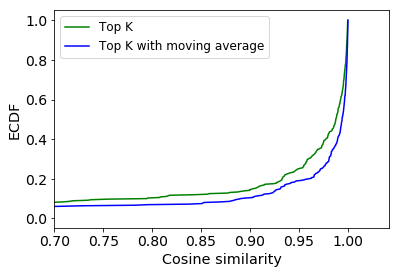

In [20]:
#gw_table_similarity_ma.set_index(pd.DatetimeIndex(gw_table_similarity_ma['timestamp']))
#gw_table_similarity.set_index(pd.DatetimeIndex(gw_table_similarity['timestamp']))
#gw_table_similarity_ma_top.set_index(pd.DatetimeIndex(gw_table_similarity_ma_top['timestamp']))

gw_table_similarity_no_ma.set_index(pd.DatetimeIndex(gw_table_similarity_no_ma['timestamp']))
gw_table_similarity_no_ma_top4.set_index(pd.DatetimeIndex(gw_table_similarity_no_ma_top4['timestamp']))

getECDF(gw_table_similarity_no_ma_top4).plot(color='green')
#getECDF(gw_table_similarity_no_ma_top5).plot(color='blue')
#getECDF(gw_table_similarity_no_ma_top6).plot(color='orange')
#getECDF(gw_table_similarity_no_ma_top7).plot(color='cyan')

#getECDF(gw_table_similarity).plot(color='red')
#getECDF(gw_table_similarity_no_ma).plot(color='red')

getECDF(gw_table_similarity_ma_top).plot(color='blue')

plt.legend(['Top K', 'Top K with moving average'], fontsize = 'large')
plt.ylabel('ECDF', fontsize = 'x-large')
plt.xlabel('Cosine similarity', fontsize = 'x-large')

plt.xlim(0.7)

plt.tick_params(axis='both', which='major', labelsize=14)
#plot.tick_params(axis='both', which='minor', labelsize=8)


plt.show()

In [116]:
temp =  pd.read_csv(os.path.join('error_similarity_mi.csv'), sep=',', index_col='timestamp')
temp.head()

,error 5%,error 10%,error 15%
timestamp,,,
"01/21/2019, 14:32:00",0.998256,0.999918,0.989352
"01/21/2019, 14:34:00",0.998236,0.999374,0.994188
"01/21/2019, 14:36:00",0.998085,0.991557,0.960755
"01/21/2019, 14:38:00",0.995195,0.518453,0.999617
"01/21/2019, 14:40:00",0.996358,0.992790,0.996701


In [112]:
def getECDF1(df, col):
    """Helper function that caclulates the ECDF of a dataframe"""
    df = df[col].value_counts()
    ecdf = df.sort_index().cumsum()*1./df.sum()    
    return ecdf

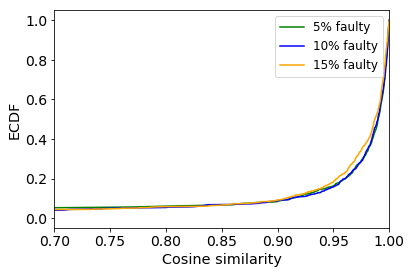

In [117]:
getECDF1(temp, 'error 5%').plot(color='green')
getECDF1(temp, 'error 10%').plot(color='blue')
getECDF1(temp, 'error 15%').plot(color='orange')
#getECDF1(temp, 'no error').plot(color='red')

plt.legend(['5% faulty', '10% faulty', '15% faulty', 'no error'], fontsize = 'large')
plt.ylabel('ECDF', fontsize = 'x-large')
plt.xlabel('Cosine similarity', fontsize = 'x-large')

plt.tick_params(axis='both', which='major', labelsize=14)

plt.xlim(0.7,1)
plt.show()

In [107]:
def change_error_pattern(clients):
    temp = data
    for client in clients:        
        df = temp[client]
        for name, grouped in df.groupby('gateway'):
            df_t = grouped.head(1440)
            cnt = 0
            for index1, row in df_t.iterrows():
                if cnt>5:
                    df.loc [ (df['timestamp'] == index1.strftime("%m/%d/%Y %H:%M:%S")) & 
                            (df['gateway'] == name), 'latency'] = row['latency']*10
                if cnt == 10:
                    cnt = 0
                cnt+=1
            
def change_error_gradual(clients):
    for client in clients:
        df_main = data[client]
        #df_main['latency'] = df_main.latency.fillna(0)
        last = None
        for name, grouped in df_main.groupby('gateway'):
            df = grouped.head(1440)
            start = 10
            s_ind = None
            end_ind = None
            for index1, row in df.iterrows():
                if s_ind == None:
                    s_ind = index1
                #df.set_value(index1.strftime("%m/%d/%Y %H:%M:%S"),'latency',  (row['latency'] + (row['latency']*start)/100))
                df_main.loc[ (df_main['timestamp'] == index1.strftime("%m/%d/%Y %H:%M:%S")) & 
                                        (df_main['gateway']== name), 'latency'] = (row['latency'] + (row['latency']*start)/100)
                start += 1
                end_ind = index1
            
            
#change_error_gradual(['c3_2'])

change_error_pattern(['c3_2'])

In [108]:
for name, grouped in data['c3_2'].groupby('gateway'):
    df = grouped.head(1440)
    print(df[['latency','gateway']])

                      latency        gateway
timestamp                                   
2019-01-21 14:35:00  0.019574  10.138.120.66
2019-01-21 14:36:00  0.257832  10.138.120.66
2019-01-21 14:37:00  0.024223  10.138.120.66
2019-01-21 14:38:00  0.022603  10.138.120.66
2019-01-21 14:39:00  0.024260  10.138.120.66
2019-01-21 14:40:00  0.024133  10.138.120.66
2019-01-21 14:41:00  0.256210  10.138.120.66
2019-01-21 14:42:00  0.214880  10.138.120.66
2019-01-21 14:43:00  0.216600  10.138.120.66
2019-01-21 14:44:00  0.229600  10.138.120.66
2019-01-21 14:45:00  0.212240  10.138.120.66
2019-01-21 14:46:00  0.022785  10.138.120.66
2019-01-21 14:47:00  0.021692  10.138.120.66
2019-01-21 14:48:00  0.023804  10.138.120.66
2019-01-21 14:49:00  0.022117  10.138.120.66
2019-01-21 14:50:00  0.022057  10.138.120.66
2019-01-21 14:51:00  0.222210  10.138.120.66
2019-01-21 14:52:00  0.202150  10.138.120.66
2019-01-21 14:53:00  0.220460  10.138.120.66
2019-01-21 14:54:00  0.220770  10.138.120.66
2019-01-21

In [49]:

data['c1_1'] = data['c1_1'].set_index('timestamp')

In [84]:
df = pd.DataFrame({'A': [1, 2, 3], 'B': [400, 500, 600]})
new_df = pd.DataFrame({'B': [5,6]})
df.update(new_df)
print(df)

   A      B
0  1    5.0
1  2    6.0
2  3  600.0
